In [1]:
import gc
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file

params_for_plots = {'legend.fontsize': 'medium',
          'figure.figsize': (30, 30),
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
plt.rcParams.update(params_for_plots)

In [2]:
dataset = "mushrooms.txt"

data = load_svmlight_file(dataset)
X, y = data[0].toarray(), data[1]
y = 2 * y - 3

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
def f(X, Y, w, mu):
    return 1/ X_train.shape[0] * np.linalg.norm(np.dot(X, w) - Y, 2) ** 2 + mu * np.linalg.norm(w, 2) ** 2

def gradient(X, Y, w, mu):
    return 2 / X_train.shape[0] * (np.dot(X.T, np.dot(X, w)) - np.dot(X.T, Y)) + 2 * mu * w

In [5]:
def gradient_descent(X, Y, w_0, alpha, epsilon, max_iter=1_000_0):
    w = w_0
    for i in range(max_iter):
        grad = gradient(X, Y, w, mu)
        w = w - alpha * grad
    return w

In [6]:
L = np.abs(np.max(np.linalg.eig(2 / X_train.shape[0] * np.dot(X_train.T, X_train))[0]))
batch_size = 10
device_num = 6
mu = L / 100
L += mu

print(L)

20.883882012008236


In [7]:
true_ans = gradient_descent(X_train, y_train, np.zeros(X_train.shape[1]), 1 / L, 1e-6)

In [8]:
true_ans

array([-3.13852180e-03,  3.56536574e-02, -2.52722516e-02, -5.42467134e-03,
        1.58181096e-02, -1.65748610e-02,  7.70227601e-03, -6.00185145e-02,
       -3.38502003e-03,  5.67627198e-02,  8.49595248e-03, -5.00375059e-02,
        5.21291028e-03,  4.37259489e-03,  3.29031420e-02, -3.86110552e-02,
        1.05251920e-02,  1.22696034e-02, -1.31750109e-02,  2.91056382e-02,
        7.61382452e-02, -7.50767839e-02,  1.03064539e-01, -9.48401806e-02,
       -2.21577155e-01, -1.88580913e-02,  9.86729046e-02,  3.63120136e-01,
       -1.17518614e-01, -5.63101907e-02, -5.46918869e-02,  2.64874894e-02,
       -2.54260281e-02, -1.18892803e-01,  1.19954264e-01,  2.13836949e-01,
       -2.12775488e-01, -1.10882487e-01,  1.98133521e-02, -1.54808059e-02,
       -3.31683415e-02,  2.52615846e-02,  1.22466444e-02,  6.05251123e-02,
        8.22169983e-04, -2.02425085e-02,  2.19232726e-02,  4.04083650e-02,
       -1.64896995e-04, -2.16033088e-02,  2.26647701e-02, -6.33401329e-04,
        9.87433073e-02, -

In [9]:
#Сгенерируем матрицу W_0 размера device_num часть значений 0 остальные от 0 до 1
W_0 = np.random.rand(device_num, device_num)
W_0 = np.tril(W_0) + np.tril(W_0, -1).T


In [10]:
W_0 = np.array([
    [0.5, 0, 0.5, 0, 0, 0],
    [0, 1 / 3, 1 / 3, 0, 1 / 3, 0],
    [0, 0.25, 0.25, 0, 0.25, 0.25],
    [0, 0, 0.5, 0.5, 0, 0],
    [0, 0.5, 0, 0, 0.5, 0],
    [0, 0, 0.5, 0, 0, 0.5]])

def fast_mix(gradients, W = W_0, rounds = 1000):
    Z = np.copy(gradients)
    Z_previous = np.copy(Z)

    lamb_2 = np.sort(np.linalg.eig(W)[0])[-2]
    eta = (1 - np.sqrt(1 - np.power(lamb_2, 2))) / (1 + np.sqrt(1 + np.power(lamb_2, 2)))

    for r in range(rounds):
        # print(type(Z_previous))
        Z_next = (1 + eta) * np.dot(Z, W) - eta * Z_previous
        Z_previous = Z
        Z = Z_next

    return Z

In [11]:
w_0 = np.zeros(X_train.shape[1])
def DVPL(X_train, y_train, max_iter, devices_num, w_0, eta_x_sigma, eta_div_L_waved, theta1, f, gradient, batch_size, L, mu, theta2=0.5, P = 1000):
    p = batch_size / X_train.shape[0] / 2
    proc = np.zeros(max_iter)
    x_axis = np.zeros(max_iter)
    # convergence = []
    y = w_0
    z = w_0
    w = w_0
    g = w_0
    z_new = w_0
    x_axis = np.zeros(max_iter)

    #как я понимаю, мы считаем сходимость через разницу между f(x) и f(x^*)
    divide_by = abs(f(X_train, y_train, w_0, mu) - f(X_train, y_train, true_ans, mu))
    # print(divide_by)
    
    batches = np.zeros((batch_size, devices_num))
    gradf_w = gradient(X_train, y_train, w, mu)
    device_features = X_train.shape[1] // devices_num
    
    for i in range(max_iter):
        x = theta1 * z + 1 / 2 * w + (1 - theta1 - 1 / 2) * y
        #как бы параллельно считаем градиенты на всех устройствах
        proc[i] = abs(f(X_train, y_train, x, mu) - f(X_train, y_train, true_ans, mu)) / divide_by
        rows = np.random.choice(X_train.shape[0], batch_size, replace=False)
        for j in range(devices_num):
            # rows[j] = np.random.choice(X_train.shape[0], batch_size, replace=False)
            X_on_device = []
            if j < devices_num:
                X_on_device = X_train[rows, j * device_features : (j + 1) * device_features]
                # X_on_device = X_train[rows[j], j * device_features : (j + 1) * device_features]
                batches[:, j] = np.dot(X_on_device, x[j * device_features : (j + 1) * device_features] - w[j * device_features : (j + 1) * device_features])
            else:
                X_on_device = X_train[rows, j * device_features:]
                batches[:, j] = np.dot(X_on_device, x[j * device_features:] - w[j * device_features:])

        # print(batches.shape)
        batches = device_num * fast_mix(batches, W = W_0, rounds = P)
        # print(batches.shape)
        # gradf_w = []
        for j in range(devices_num):
            if j < devices_num:
                g = batches[:, j]
                # print("G shape:", g.shape)
                g =  2/batch_size * np.dot(X_train[rows, j * device_features : (j + 1) * device_features].T, g) + gradf_w[j * device_features : (j + 1) * device_features]
                z_new = (eta_x_sigma * x[j * device_features : (j + 1) * device_features] + z[j * device_features : (j + 1) * device_features] - eta_div_L_waved * g) / (1 + eta_x_sigma)
                y[j * device_features : (j + 1) * device_features] = x[j * device_features : (j + 1) * device_features] + theta1 * (z_new - z[j * device_features : (j + 1) * device_features])
                z[j * device_features : (j + 1) * device_features] = np.copy(z_new)
            else:
                g = batches[:, j]
                g = 2/batch_size * np.dot(X_train[rows, j * device_features :].T, g) + gradf_w[j * device_features :]
                z_new = (eta_x_sigma * x[j * device_features :] + z[j * device_features :] - eta_div_L_waved * g) / (1 + eta_x_sigma)
                y[j * device_features :] = x[j * device_features :] + theta1 * (z_new - z[j * device_features :])
                z[j * device_features :] = np.copy(z_new)

        if (random.random() < p):
            w = np.copy(y)
            gradf_w = gradient(X_train, y_train, w, mu)
            size_to_add_when_random_eq_p = 30
            x_axis[i] = size_to_add_when_random_eq_p if i == 0 else x_axis[i - 1] + size_to_add_when_random_eq_p
        else:
            size_to_add_when_random_neq_p = 10
            x_axis[i] = size_to_add_when_random_neq_p if i == 0 else x_axis[i - 1] + size_to_add_when_random_neq_p

    return proc, x_axis

In [12]:
L_waved = L * 4 / batch_size
sigma = mu / L_waved

theta1 = min(np.sqrt(2 * sigma * 2 * X_train.shape[0] / batch_size / 3), 1/2)
stepsize = 1/2 / (1 + 1/2) / theta1

eta_x_sigma = stepsize * sigma
eta_div_L_waved = stepsize / L_waved

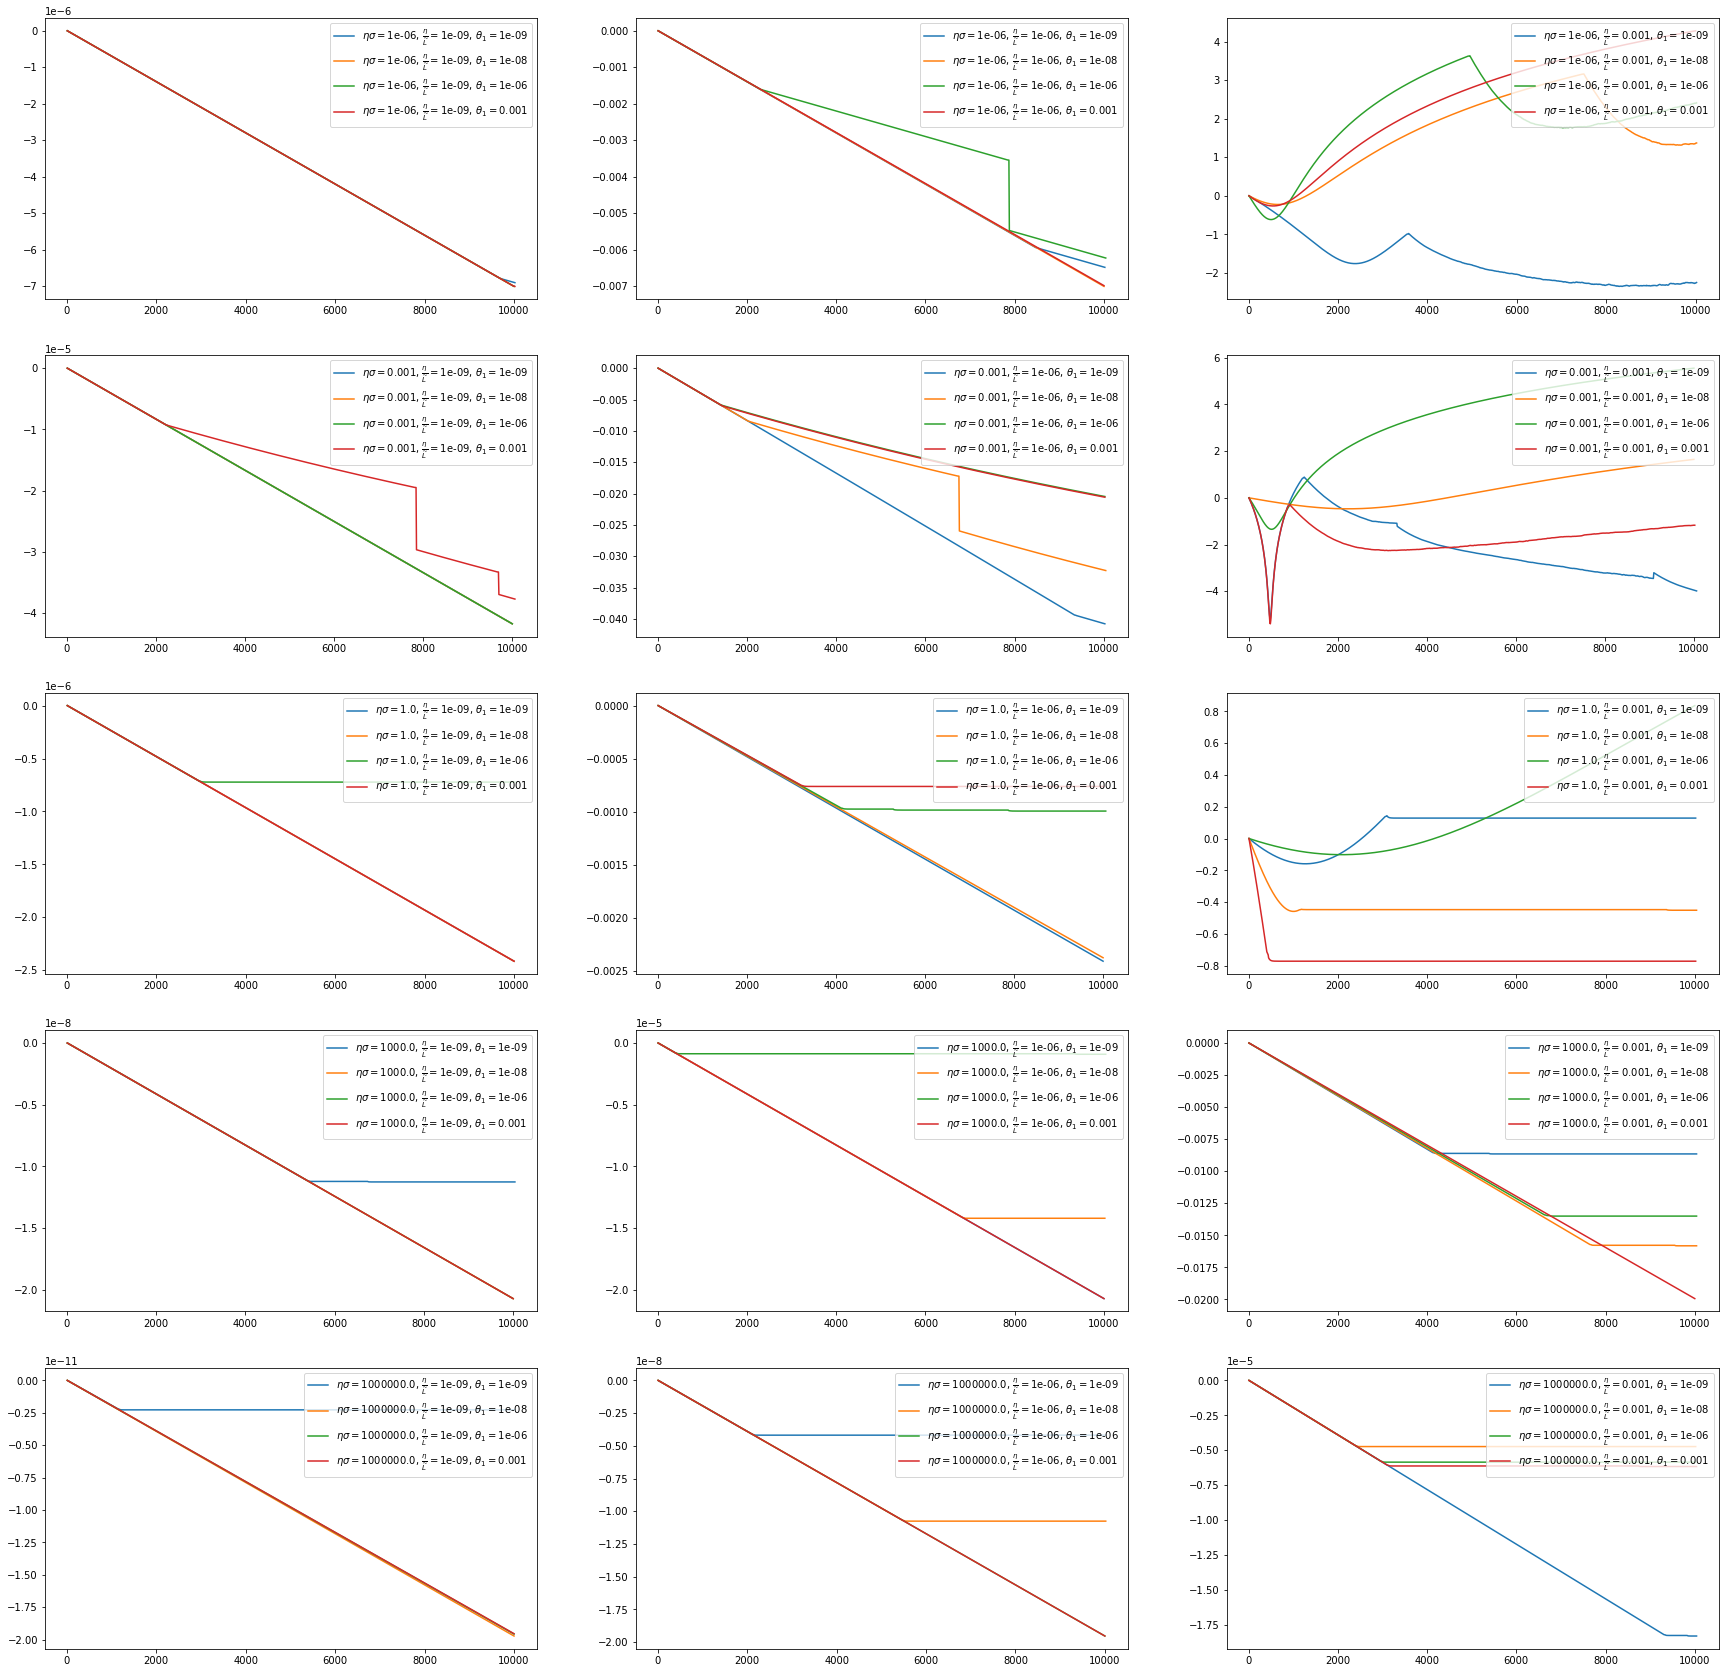

In [13]:
from matplotlib import pyplot as plt

eta_x_sigma_s = np.array([1/1000000, 1/1000, 1, 1000, 1000000])
eta_div_L_waved_s = np.array([1/1000000000, 1/1000000, 1/1000])
theta1_s = np.array([1/1000000000, 1/100000000, 1/1000000, 1/1000])
fig, axs = plt.subplots(eta_x_sigma_s.size, eta_div_L_waved_s.size)

for i in range(eta_x_sigma_s.size):
    for j in range(eta_div_L_waved_s.size):
        for k in range(theta1_s.size):
            #eta_x_sigma = eta_x_sigma_s[i] * eta_x_sigma
            #eta_div_L_waved = eta_div_L_waved_s[j] * eta_div_L_waved
            #theta1 = theta1_s[k] * theta1
            eta_x_sigma = eta_x_sigma_s[i]
            eta_div_L_waved = eta_div_L_waved_s[j]
            theta1 = theta1_s[k]
            proc, x_axis = DVPL(X_train = X_train, 
                                y_train = y_train, 
                                max_iter = 1000, 
                                devices_num = device_num, 
                                w_0 = w_0, 
                                eta_x_sigma = eta_x_sigma, 
                                eta_div_L_waved = eta_div_L_waved, 
                                theta1 = theta1, 
                                f = f, 
                                gradient = gradient, 
                                batch_size = batch_size,
                                L = L,
                                mu = mu, 
                                P = 1000)
            axs[i, j].plot(x_axis, np.log(proc), label=R"$\eta \sigma=$" + str(eta_x_sigma_s[i]) + R", $\frac{\eta}{\widetilde{L}}=$" + str(eta_div_L_waved_s[j]) + R", $\theta_1=$" + str(theta1_s[k]))
        axs[i, j].legend(loc="upper right")